LINKS (will be removing this later and will add it in the doc):

[HOLC data](https://github.com/americanpanorama/mapping-inequality-census-crosswalk)

[Economic data](https://data.census.gov/table/ACSDP1Y2021.DP03?q=DP03:+SELECTED+ECONOMIC+CHARACTERISTICS)

[Demopgraphic data](https://data.census.gov/table/ACSDP5Y2020.DP05?q=DP05:+ACS+DEMOGRAPHIC+AND+HOUSING+ESTIMATES&g=050XX00US36005$1400000,36047$1400000,36061$1400000,36081$1400000,36085$1400000&y=2020)

[Housing data](https://data.census.gov/table/ACSDP1Y2021.DP04?q=DP04:+SELECTED+HOUSING+CHARACTERISTICS)

To gain a deeper insight and a better understanding of which factors influence these prices, we have enriched our core dataset with historical and socio-economic layers. Firstly we incorporate historical data from the Home Owners' Loan Corporation (HOLC). This dataset provides a window into the 1930s 'redlining' practices, where neighborhoods were graded from 'A' (best) to 'D' (Hazardous) which was often rooted in racial discrimination.  

The original data is geographic, as each area is represented as a polyglon with an associated HOLC grade. To analyze this data alongside the housing prices we have converted it into a tabular format, where each row corresponds to a census tract and contains the key properties:
- `GEOID` = the unique identifier for the tract
- `grade` = the HOLC grade assigned to that area
- `pct_tract` = the percentage of the tract covered by this HOLC area
- `city and state` = the location

To ensure each tract has a single HOLC grade, we use the majority grad, which is the grade covering the largest portion of the tract. This tabular format allows us to easily merge the historical redlining data with the current housing data and perform an analysis. 

Importing the necessary libraries

In [52]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Loading in the GeoJSON file

In [49]:
HOLC_data = gpd.read_file('MIv3Areas_2020TractCrosswalk.geojson')
HOLC_data.head()

,area_id,city,state,city_survey,cat,grade,label,res,com,ind,fill,GISJOIN,GEOID,calc_area,pct_tract,geometry
0,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,G0100730010801,01073010801,3.459131e+05,0.06848,"MULTIPOLYGON (((-86.7722 33.48494, -86.77206 3..."
1,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,G0100730010802,01073010802,2.155205e+06,0.38611,"MULTIPOLYGON (((-86.77244 33.48455, -86.77239 ..."
2,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,G0100730010803,01073010803,2.322751e+04,0.00273,"MULTIPOLYGON (((-86.73481 33.49402, -86.73086 ..."
3,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,G0100730010804,01073010804,1.392696e+06,0.19737,"MULTIPOLYGON (((-86.7462 33.4849, -86.74725 33..."
4,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,G0100730010806,01073010806,8.334346e+05,0.06635,"MULTIPOLYGON (((-86.74596 33.48514, -86.74606 ..."


Filtering and selecting rows

In [55]:
cols = ["GEOID", "grade", "pct_tract", "city", "state"] # rows we want to keep
df_holc = HOLC_data[HOLC_data['state'] == 'NY'][cols] # only selecting New York
df_holc.to_csv("New York HOLC Data.csv") # saving it as a csv
df_holc.head()

,GEOID,grade,pct_tract,city,state
31674,36001001600,A,0.06360,Albany,NY
31675,36001001700,A,0.06299,Albany,NY
31676,36001001803,A,0.02913,Albany,NY
31677,36001001804,A,0.13784,Albany,NY
31678,36001001901,A,0.20460,Albany,NY


Missing value analysis

Missing HOLC grades: 1268
Missing GEOIDs: 72


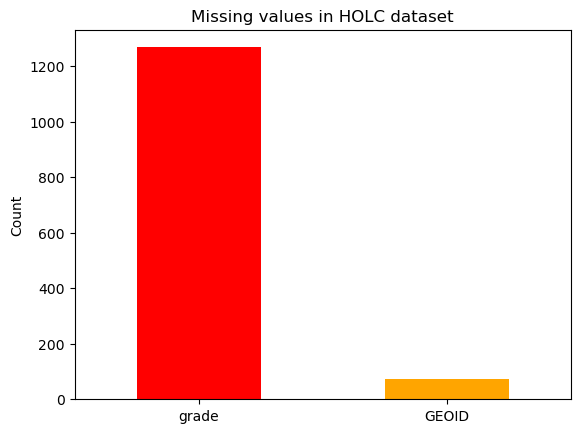

In [54]:
missing_values = df_holc.isnull().sum()

print(f"Missing HOLC grades: {missing_values['grade']}")
print(f"Missing GEOIDs: {missing_values['GEOID']}")

# visualising results
cols_to_show = ['grade', 'GEOID']
missing_values[cols_to_show].plot(kind='bar', color=['red', 'orange'])
plt.title('Missing values in HOLC dataset')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The dataset remains unstructured, with 1,268 missing HOLC ratings (`grade`) and 72 missing `GEOIDs`. Additionally, an unnecessary index column (`Unnamed: 0`) clutters the overview and identification numbers occasionally appear in unreadable scientific notation. Since nearly 20% of the data is incomplete, cleaning is required to ensure reliable calculations and prevent alignment issues. 

In [ ]:
df_holc_clean = df_holc.dropna(subset=['grade', 'GEOID']) # dropping all the empty rows
df_holc_cleaned = df_holc_clean.reset_index(drop=True) # fixing the rows (indexing)
df_holc_clean.to_csv("Cleaned HOLC dataset.csv")
df_holc_clean.head()

,GEOID,grade,pct_tract,city,state
31674,36001001600,A,0.06360,Albany,NY
31675,36001001700,A,0.06299,Albany,NY
31676,36001001803,A,0.02913,Albany,NY
31677,36001001804,A,0.13784,Albany,NY
31678,36001001901,A,0.20460,Albany,NY


While the HOLC data represents the historical framework, the ACS data we've acquired provides a better snapshot of the current demographic and economic landscape of New York City's neighborhoods. As the Cencus Bureau datasets contain long identifiers and include data for the entire country, the data had to be standardized first to make these files workable for our specific research. By standardizing the original `GEO_ID` columns long-form string to only 11 characters, we are able to create a 11-digit GEOID that serves as the universal key for identifying Census Tracts across datasets. 

Importing and standardizing the data

In [68]:
# reading in the csv files, skipping the first row with metadata
df_economics = pd.read_csv('data/selection/economics.csv', low_memory=False).iloc[1:].copy()
df_demographic = pd.read_csv('data/selection/demographic.csv', low_memory=False).iloc[1:].copy()
df_housing = pd.read_csv('data/selection/housing characteristics.csv', low_memory=False).iloc[1:].copy()

# making GEOIDs (last 11 characters of GEO_ID)
for df in [df_economics, df_demographic, df_housing]:
    df['GEOID'] = df['GEO_ID'].str[-11:]

# filtering on NYC (borough codes)
nyc_borough_codes = [
    '36005', # Bronx
    '36047', # Brooklyn
    '36061', # Manhattan
    '36081', # Queens
    '36085' # Staten Islands
    ]

df_nyc_economics = df_economics[df_economics['GEOID'].str.startswith(tuple(nyc_borough_codes))].copy()
df_nyc_demographic = df_demographic[df_demographic['GEOID'].str.startswith(tuple(nyc_borough_codes))].copy()
df_nyc_housing = df_housing[df_housing['GEOID'].str.startswith(tuple(nyc_borough_codes))].copy()


In order to capture a multidimensional view of each census tract, we have integrated variables across three domains:

- Economics: including `Median_household_income`, `Unemployment_rate`, and `Poverty_rate` to assess the financial health of the area.
- Demographic: data on race and ethnictiy, such as `Hispanic_Latino`, `White_Non_Hispanic`, `Black_Non_Hispanic`, and `Asian_Non_Hispanic` to examine patterns of residential segregation.
- Housing: variables such as `Median_gross_rent`, `Owner_occupied_pct`, and `Rent_burden_35_pct_plus` to understand housing affordability and tenure.

1. Economic data selection

In [ ]:
# loading in the metadata
metadata_economics = pd.read_csv('data/ACSDP5Y2020.DP03_2026-01-17T103152/ACSDP5Y2020.DP03-Column-Metadata.csv') 

# filtering on keywords and selecting columns
keywords = 'EMPLOYMENT STATUS|INCOME AND BENEFITS|POVERTY LEVEL|CLASS OF WORKER'
economics_columns_meta = metadata_economics[metadata_economics['Label'].str.contains(keywords, case=False, na=False)]
economics_column_names = economics_columns_meta['Column Name'].tolist()
columns_to_select = ['GEO_ID', 'GEOID', 'NAME'] + economics_column_names
existing_columns = [col for col in columns_to_select if col in df_nyc_economics]
df_ecom = df_nyc_economics[existing_columns].copy() # making the table

# mapping and renaming ecom categories
mapping_ecom = {
    'GEOID': 'GEOID',
    'NAME': 'Neighbourhood_name', 
    'DP03_0062E': 'Median_household_income',
    'DP03_0009PE': 'Unemployment_rate',      
    'DP03_0128PE': 'Poverty_rate',           
    'DP03_0047PE': 'Private_workers_percent' 
}
df_ecom_clean = df_nyc_economics.rename(columns=mapping_ecom)
df_ecom_clean = df_ecom_clean[list(mapping_ecom.values())].copy()

# making the numbers numeric
cols_to_fix = ['Median_household_income', 'Unemployment_rate', 'Poverty_rate', 'Private_workers_percent']
df_ecom_clean[cols_to_fix] = df_ecom_clean[cols_to_fix].apply(pd.to_numeric, errors='coerce')

df_ecom_clean = df_ecom_clean[df_ecom_clean['GEOID'] != '36005000100'] # dropping this, because it's Rikers Island (prison)
df_ecom_clean = df_ecom_clean.reset_index(drop=True)
df_ecom_clean.index = df_ecom_clean.index + 1 # cleaning index

# printing results
df_ecom_clean.head()

,GEOID,Neighbourhood_name,Median_household_income,Unemployment_rate,Poverty_rate,Private_workers_percent
1,36005000200,"Census Tract 2, Bronx County, New York",68000.0,10.8,21.4,68.3
2,36005000400,"Census Tract 4, Bronx County, New York",93155.0,4.6,4.3,70.4
3,36005001600,"Census Tract 16, Bronx County, New York",34766.0,8.8,18.2,72.0
4,36005001901,"Census Tract 19.01, Bronx County, New York",61711.0,4.4,25.5,78.6
5,36005001902,"Census Tract 19.02, Bronx County, New York",53882.0,7.8,22.6,86.8


2. Demographic selection

In [ ]:
# loading in the metadata
metadata_demographic = pd.read_csv('data/ACSDP5Y2020.DP05_2026-01-17T104828/ACSDP5Y2020.DP05-Column-Metadata.csv') 

# selecting all columns that contain 'race'
race_columns_meta = metadata_demographic[metadata_demographic['Label'].str.contains('RACE', case=False, na=False)]
race_column_names = race_columns_meta['Column Name'].tolist()
columns_to_select = ['GEO_ID', 'GEOID', 'NAME'] + race_column_names
existing_columns = [col for col in columns_to_select if col in df_nyc_demographic.columns]

# making the table
df_race = df_nyc_demographic[existing_columns].copy()

# mapping and renaming demographic categories
mapping_demo = {
    'GEOID': 'GEOID',
    'NAME': 'Neighbourhood_name',
    'DP05_0033E': 'Total_population',
    'DP05_0071E': 'Hispanic_Latino',
    'DP05_0077E': 'White_Non_Hispanic',
    'DP05_0078E': 'Black_Non_Hispanic',
    'DP05_0080E': 'Asian_Non_Hispanic',
    'DP05_0079E': 'Native_American_Non_Hispanic',
    'DP05_0082E': 'Other_Non_Hispanic',
    'DP05_0083E': 'Two_Or_More_Races_Non_Hispanic'
}
df_race_clean = df_nyc_demographic[list(mapping_demo.keys())].copy()
df_race_clean = df_race_clean.rename(columns=mapping_demo)

# making the numbers numeric
cols_to_fix = [c for c in df_race_clean.columns if c not in ['GEOID', 'Neighbourhood_name']]
df_race_clean[cols_to_fix] = df_race_clean[cols_to_fix].apply(pd.to_numeric, errors='coerce')

df_race_clean = df_race_clean[df_race_clean['GEOID'] != '36005000100'] # Rikers Island 
df_race_clean = df_race_clean.reset_index(drop=True) 
df_race_clean.index = df_race_clean.index + 1 # cleaning index

# printing results
df_race_clean.head()

,GEOID,Neighbourhood_name,Total_population,Hispanic_Latino,White_Non_Hispanic,Black_Non_Hispanic,Asian_Non_Hispanic,Native_American_Non_Hispanic,Other_Non_Hispanic,Two_Or_More_Races_Non_Hispanic
1,36005000200,"Census Tract 2, Bronx County, New York",4167,2943,77,980,115,0,52,0
2,36005000400,"Census Tract 4, Bronx County, New York",5684,4148,371,965,87,0,2,111
3,36005001600,"Census Tract 16, Bronx County, New York",5917,3335,229,1986,63,192,55,57
4,36005001901,"Census Tract 19.01, Bronx County, New York",1910,1029,259,610,0,0,0,12
5,36005001902,"Census Tract 19.02, Bronx County, New York",1334,640,201,373,47,0,9,64


3. Housing selection

In [ ]:
# loading in the metadata
metadata_housing = pd.read_csv('data/ACSDP5Y2020.DP04_2026-01-17T103955/ACSDP5Y2020.DP04-Column-Metadata.csv')

# filtering on keywords and selecting columns
keywords = 'HOUSING TENURE|GROSS RENT|OCCUPANTS PER ROOM'
housing_columns_meta = metadata_housing[metadata_housing['Label'].str.contains(keywords, case=False, na=False)]
housing_column_names = housing_columns_meta['Column Name'].tolist()
columns_to_select = ['GEO_ID', 'GEOID', 'NAME'] + housing_column_names
existing_columns = [col for col in columns_to_select if col in df_nyc_housing]

# making the table
df_house = df_nyc_housing[existing_columns].copy

# mapping and renaming housing categories
mapping_housing = {
    'GEOID': 'GEOID',
    'NAME': 'Neighborhood_name',
    'DP04_0046PE': 'Owner_occupied_pct',     # Housing Tenure (Owner)
    'DP04_0047PE': 'Renter_occupied_pct',    # Housing Tenure (Renter)
    'DP04_0134E':  'Median_gross_rent',      # Gross Rent (Dollars)
    'DP04_0142PE': 'Rent_burden_35pct_plus', # Rent as % of income (>35%)
    'DP04_0079PE': 'Overcrowding_1_01_to_1_50_pct', # Occupants per room (High)
    'DP04_0080PE': 'Overcrowding_1_51_plus_pct'     # Occupants per room (Very High)
}
df_housing_clean = df_nyc_housing.rename(columns=mapping_housing)
df_housing_clean = df_housing_clean[list(mapping_housing.values())].copy()

# making the numbers numeric
cols_to_fix_h = [c for c in df_housing_clean.columns if c not in ['GEOID', 'Neighborhood_name']]
df_housing_clean[cols_to_fix_h] = df_housing_clean[cols_to_fix_h].apply(pd.to_numeric, errors='coerce')

df_housing_clean = df_housing_clean[df_housing_clean['GEOID'] != '36005000100'] # Rikers Island
df_housing_clean = df_housing_clean.reset_index(drop=True)
df_housing_clean.index = df_housing_clean.index + 1 # cleaning index

df_housing_clean.head() # printing the result

,GEOID,Neighborhood_name,Owner_occupied_pct,Renter_occupied_pct,Median_gross_rent,Rent_burden_35pct_plus,Overcrowding_1_01_to_1_50_pct,Overcrowding_1_51_plus_pct
1,36005000200,"Census Tract 2, Bronx County, New York",57.9,42.1,1701.0,56.5,2.2,776
2,36005000400,"Census Tract 4, Bronx County, New York",73.4,26.6,1580.0,44.6,0.0,1549
3,36005001600,"Census Tract 16, Bronx County, New York",12.0,88.0,954.0,26.8,3.9,259
4,36005001901,"Census Tract 19.01, Bronx County, New York",1.0,99.0,1284.0,43.1,0.0,8
5,36005001902,"Census Tract 19.02, Bronx County, New York",18.2,81.8,1536.0,43.0,1.2,60


Merging the ACS data into one census package

In [71]:
# merging economic data with race using GEOID
census_package = df_ecom_clean.merge(
    df_race_clean.drop(columns=['Neighbourhood_name']), # dropping Neighbourhood_name to avoid duplicate columns
    on='GEOID', how='inner') 

# merging house data into the existing census package
census_package = census_package.merge(
    df_housing_clean.drop(columns=['Neighborhood_name']), 
    on='GEOID', how='inner')

census_package = census_package.reset_index(drop=True) 
census_package.index = census_package.index + 1

census_package.head() # printing the result

,GEOID,Neighbourhood_name,Median_household_income,Unemployment_rate,Poverty_rate,Private_workers_percent,Total_population,Hispanic_Latino,White_Non_Hispanic,Black_Non_Hispanic,Asian_Non_Hispanic,Native_American_Non_Hispanic,Other_Non_Hispanic,Two_Or_More_Races_Non_Hispanic,Owner_occupied_pct,Renter_occupied_pct,Median_gross_rent,Rent_burden_35pct_plus,Overcrowding_1_01_to_1_50_pct,Overcrowding_1_51_plus_pct
1,36005000200,"Census Tract 2, Bronx County, New York",68000.0,10.8,21.4,68.3,4167,2943,77,980,115,0,52,0,57.9,42.1,1701.0,56.5,2.2,776
2,36005000400,"Census Tract 4, Bronx County, New York",93155.0,4.6,4.3,70.4,5684,4148,371,965,87,0,2,111,73.4,26.6,1580.0,44.6,0.0,1549
3,36005001600,"Census Tract 16, Bronx County, New York",34766.0,8.8,18.2,72.0,5917,3335,229,1986,63,192,55,57,12.0,88.0,954.0,26.8,3.9,259
4,36005001901,"Census Tract 19.01, Bronx County, New York",61711.0,4.4,25.5,78.6,1910,1029,259,610,0,0,0,12,1.0,99.0,1284.0,43.1,0.0,8
5,36005001902,"Census Tract 19.02, Bronx County, New York",53882.0,7.8,22.6,86.8,1334,640,201,373,47,0,9,64,18.2,81.8,1536.0,43.0,1.2,60


Since the HOLC data has already been mapped to 2020 Census Tract boundaries, we can directly link historical grades to modern socio-economic data. However, as some 2020 tracts overlap with multiple historical HOLC zones, we first identify the dominant grade (the one with the highest pct_tract) for each neighborhood.

In [ ]:
# selecting the dominant HOLC grade per GEOID
df_holc_dominant = df_holc_clean.sort_values(['GEOID', 'pct_tract'], ascending=[True, False]).drop_duplicates('GEOID') 

# merging the HOLC data with the census package using GEOID
final_analysis_df = census_package.merge(df_holc_dominant, on='GEOID', how='inner')

# removing empty rows and cleaning index
final_analysis_df = final_analysis_df.dropna(subset=['Median_household_income', 'Median_gross_rent'])
final_analysis_df = final_analysis_df.reset_index(drop=True)
final_analysis_df.index = final_analysis_df.index + 1

final_analysis_df.to_csv("Full extra data set.csv", index=True) # saving csv

final_analysis_df.head() # printing the result

,GEOID,Neighbourhood_name,Median_household_income,Unemployment_rate,Poverty_rate,Private_workers_percent,Total_population,Hispanic_Latino,White_Non_Hispanic,Black_Non_Hispanic,...,Owner_occupied_pct,Renter_occupied_pct,Median_gross_rent,Rent_burden_35pct_plus,Overcrowding_1_01_to_1_50_pct,Overcrowding_1_51_plus_pct,grade,pct_tract,city,state
1,36005000200,"Census Tract 2, Bronx County, New York",68000.0,10.8,21.4,68.3,4167,2943,77,980,...,57.9,42.1,1701.0,56.5,2.2,776,D,0.57685,Bronx,NY
2,36005000400,"Census Tract 4, Bronx County, New York",93155.0,4.6,4.3,70.4,5684,4148,371,965,...,73.4,26.6,1580.0,44.6,0.0,1549,D,0.79310,Bronx,NY
3,36005001600,"Census Tract 16, Bronx County, New York",34766.0,8.8,18.2,72.0,5917,3335,229,1986,...,12.0,88.0,954.0,26.8,3.9,259,D,0.92401,Bronx,NY
4,36005001901,"Census Tract 19.01, Bronx County, New York",61711.0,4.4,25.5,78.6,1910,1029,259,610,...,1.0,99.0,1284.0,43.1,0.0,8,D,0.28115,Bronx,NY
5,36005001902,"Census Tract 19.02, Bronx County, New York",53882.0,7.8,22.6,86.8,1334,640,201,373,...,18.2,81.8,1536.0,43.0,1.2,60,D,0.23604,Bronx,NY
